# Simulated annealing Demo 3

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output, display

In [4]:
def _display_progress(current_progress, progress):
        idx = np.where(progress - current_progress >= 0)[0][0] + 1
        perc = int(100. * idx / progress.shape[0])
        clear_output(wait = True)
        prg = "["
        prg += "".join(["=" for i in range(int(perc / 5))])
        prg += "".join(["." for i in range(20 - int(perc / 5))])
        prg += "".join("]")
        display(prg + "       " + 'Progress: ' + str(perc) + "%")

In [5]:
import sys

sys.path.insert(0, "../../src")

In [6]:
from env.light_grid import LightGrid
from walker.light_walker import LightWalker
from walker.simulated_annealing import SimulatedAnnealing

In [7]:
x_l, x_r = -10, 10

In [32]:
def global_optimizer(x):
    return 5 - 0.04 * x * np.sin(x + 1 + 0.1 * x ** 2)

In [33]:
xx = np.linspace(x_l, x_r, 1000)

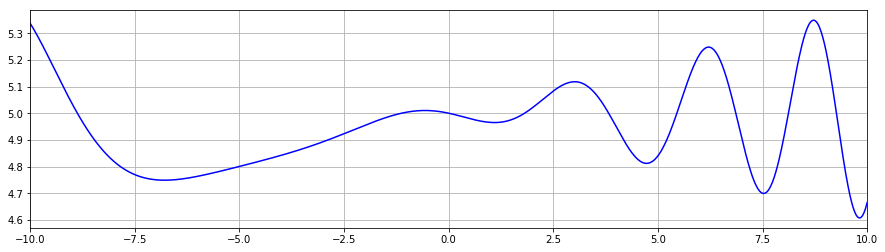

In [47]:
fig, ax = plt.subplots()

fig.set_figwidth(15)

ax.set_xlim(x_l, x_r)
ax.plot(xx, global_optimizer(xx), c = 'b')
ax.grid()
plt.show()

In [48]:
annealing = SimulatedAnnealing(initial_temperature = 10000, temperature_decay = 0.99)

In [49]:
grid = LightGrid(bounded = True, bounds = [(x_l, x_r)], dr = np.ones(2) * 1e-3, dim = 1)
grid.add_processor(global_optimizer, name = "optimizer")

In [50]:
no_of_walkers = 10
no_of_steps = int(5e2)

def get_initial_coordinates(no, x_bounds):
    return np.random.uniform(low = x_bounds[0], high = x_bounds[1], size = no)

In [51]:
walkers = []

In [52]:
coordinates = get_initial_coordinates(no_of_walkers, (-10, 10))

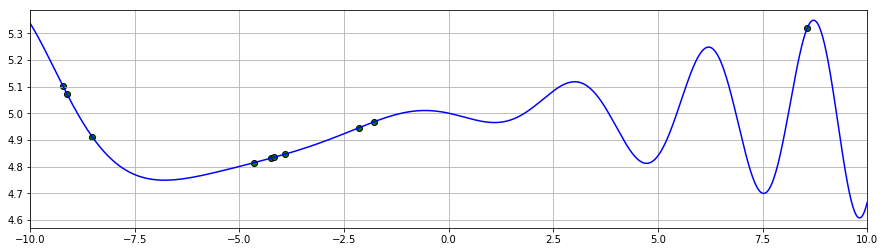

In [53]:
ax.scatter(coordinates, global_optimizer(coordinates), c = 'g', edgecolor = 'k')
fig

In [54]:
for i in range(no_of_walkers):
    wlk = LightWalker(dim = 1, \
                 data_collection_keys = ['optimizer'], \
                 max_no_of_steps = no_of_steps, \
                 initial_position = np.array([coordinates[i]]), \
                 next_step_processor = annealing)
    walkers.append(wlk)

In [55]:
drs = [np.ones(2, dtype = np.float64) * 1e-1, \
       np.ones(2, dtype = np.float64) * 1e-2, \
       np.ones(2, dtype = np.float64) * 1e-3, \
       np.ones(2, dtype = np.float64) * 1e-4]

In [56]:
from random import choice

In [57]:
prg = np.linspace(0, no_of_steps, no_of_steps)

global_min = 1e5
coord_min = 0

for i in range(no_of_steps):
    next_positions = 0
    for walker in walkers:
        curr = walker.get_current_position()
        data_collector = list(key for key in walker.data.keys())[0]
        #dr = np.random.norma(low = 0, high = 1, size = 1)
        dr = choice(drs)
        next_positions = grid._next(curr, dr = dr)
        eng_curr = grid.processors[data_collector](curr[0])
        eng_next = np.array([grid.processors[data_collector](next_pos[0]) for next_pos in next_positions])
        walker.walk(possible_states = next_positions, energies = eng_next, current_energy = eng_curr)
        tmp = walker.get_current_position()
        if global_optimizer(tmp) < global_min:
            coord_min = curr
            global_min = global_optimizer(tmp)
    _display_progress(i, prg)

'[====================]       Progress: 100%'

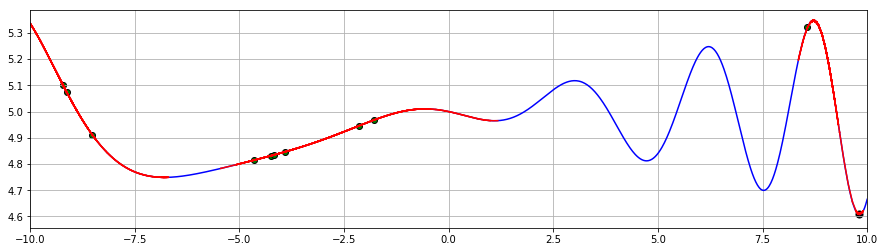

In [58]:
for wlk in walkers:
    ax.plot(wlk.visited[:, 0], global_optimizer(wlk.visited[:, 0]), c = 'r')
ax.scatter(coord_min, global_min, c = 'k', s = 50)
fig

In [59]:
global_min, coord_min

(array([4.6075477]), array([9.80781252]))